<a href="https://colab.research.google.com/github/estrelasdomackenzie/Projeto_Aplicado_III_Tecnologia_em_Ciencia_de_Dados/blob/main/Analise_Sistema_Recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QUADRANTE 1 - Imports, Configuração e Classe do Sistema

In [4]:
# -*- coding: utf-8 -*-
"""
Sistema de Recomendação de Médicos Especialistas
Universidade Presbiteriana Mackenzie
Projeto Aplicado III
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from difflib import SequenceMatcher
from collections import Counter

warnings.filterwarnings('ignore')

MAX_K = 15
CV_FOLDS = 3


class SistemaRecomendacaoMedica:

    def __init__(self, k=5):
        self.k = k
        self.modelo = None
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='mean')
        self.encoder = LabelEncoder()
        self.colunas_sintomas = []
        self.dataset = None
        self.metricas = {}
        self.mapa_especialidades = {}
        self.y_proba_test = None

    def _similaridade_strings(self, str1, str2):
        return SequenceMatcher(None, str1.lower(), str2.lower()).ratio()

    def _buscar_match_parcial(self, doenca, mapa_csv, threshold=0.6):
        melhor_match = None
        melhor_score = threshold
        doenca_lower = doenca.lower()
        palavras_doenca = set(doenca_lower.split())

        for doenca_csv, especialista in mapa_csv.items():
            doenca_csv_lower = doenca_csv.lower()
            palavras_csv = set(doenca_csv_lower.split())

            if palavras_doenca & palavras_csv:
                score = len(palavras_doenca & palavras_csv) / max(len(palavras_doenca), len(palavras_csv))
                if score > melhor_score:
                    melhor_score = score
                    melhor_match = especialista

            if doenca_lower in doenca_csv_lower or doenca_csv_lower in doenca_lower:
                score = min(len(doenca_lower), len(doenca_csv_lower)) / max(len(doenca_lower), len(doenca_csv_lower))
                if score > melhor_score:
                    melhor_score = score
                    melhor_match = especialista

            sim = self._similaridade_strings(doenca, doenca_csv)
            if sim > melhor_score:
                melhor_score = sim
                melhor_match = especialista

        return melhor_match, melhor_score if melhor_match else (None, 0)

    def carregar_dados(self, arquivo_sintomas, arquivo_especialidades=None):
        self.dataset = pd.read_csv(arquivo_sintomas)
        total = len(self.dataset)
        print(f"\nRegistros carregados: {total:,}")

        self.colunas_sintomas = [col for col in self.dataset.columns if col != 'diseases']

        if arquivo_especialidades:
            self._carregar_especialidades(arquivo_especialidades)
        else:
            self._mapear_especialidades_automatico()

    def _carregar_especialidades(self, arquivo):
        df = None
        for enc in ['utf-8', 'latin-1', 'cp1252']:
            try:
                df = pd.read_csv(arquivo, encoding=enc)
                break
            except:
                continue
        if df is None:
            return

        df.columns = df.columns.str.strip()
        if 'Disease' not in df.columns or 'Specialist' not in df.columns:
            return

        mapa_csv = {
            str(row['Disease']).strip(): str(row['Specialist']).strip()
            for _, row in df.iterrows()
            if pd.notna(row['Disease']) and pd.notna(row['Specialist'])
        }

        for doenca in self.dataset['diseases'].unique():
            if doenca in mapa_csv:
                self.mapa_especialidades[doenca] = mapa_csv[doenca]
            else:
                match_case = False
                for d_csv, e_csv in mapa_csv.items():
                    if d_csv.lower() == doenca.lower():
                        self.mapa_especialidades[doenca] = e_csv
                        match_case = True
                        break
                if not match_case:
                    especialista, _ = self._buscar_match_parcial(doenca, mapa_csv)
                    self.mapa_especialidades[doenca] = especialista or 'Clínico Geral'

    def _mapear_especialidades_automatico(self):
        for doenca in self.dataset['diseases'].unique():
            self.mapa_especialidades[doenca] = 'Clínico Geral'

    def analise_dados(self):
        top = self.dataset['diseases'].value_counts().head(10)
        print("\nTop 10 doenças mais frequentes:")
        for i, (doenca, count) in enumerate(top.items(), 1):
            print(f"{i:2}. {doenca[:40]:<40} {count:4} casos")

    def preparar_dados(self):
        X = self.dataset[self.colunas_sintomas].values
        y = self.dataset['diseases'].values

        contagem = Counter(y)
        classes_raras = [c for c, n in contagem.items() if n < 2]
        if classes_raras:
            mask = ~self.dataset['diseases'].isin(classes_raras)
            X = self.dataset[mask][self.colunas_sintomas].values
            y = self.dataset[mask]['diseases'].values

        X = self.imputer.fit_transform(X)
        y_encoded = self.encoder.fit_transform(y)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)

        return X_train, X_test, y_train, y_test

    def otimizar_k(self, X_train, y_train):
        k_valores = list(range(3, MAX_K + 1, 2))
        scores = []

        print("\n" + "=" * 50)
        print("Otimização do K")
        print("=" * 50)

        for k in k_valores:
            score = cross_val_score(
                KNeighborsClassifier(n_neighbors=k, n_jobs=-1),
                X_train,
                y_train,
                cv=CV_FOLDS
            ).mean()
            scores.append(score)
            print(f"K = {k:2d} | Acurácia = {score:.4f} ({score*100:.2f}%)")

        melhor_k = k_valores[np.argmax(scores)]
        melhor_score = max(scores)

        print("=" * 50)
        print(f"Melhor K = {melhor_k} (Acurácia = {melhor_score:.4f})")
        print("=" * 50 + "\n")

        plt.figure(figsize=(10, 6))
        plt.plot(k_valores, scores, 'b-o')
        plt.xlabel('K')
        plt.ylabel('Acurácia')
        plt.title('Otimização do K')
        plt.grid(True, alpha=0.3)
        plt.axvline(melhor_k, color='r', linestyle='--', label=f'K={melhor_k}')
        plt.legend()
        plt.tight_layout()
        plt.show()

        self.k = melhor_k
        return melhor_k

    def treinar(self, X_train, y_train):
        self.modelo = KNeighborsClassifier(
            n_neighbors=self.k,
            weights='distance',
            n_jobs=-1
        )
        self.modelo.fit(X_train, y_train)

    def avaliar(self, X_test, y_test):
        print("\n" + "=" * 70)
        print("Avaliação do Modelo")
        print("=" * 70)

        y_pred = self.modelo.predict(X_test)
        y_proba = self.modelo.predict_proba(X_test)

        self.y_proba_test = y_proba

        self.metricas['accuracy'] = accuracy_score(y_test, y_pred)
        self.metricas['precision'] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        self.metricas['recall'] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        self.metricas['f1'] = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print("\nMétricas de Performance:")
        print(f"Acurácia:  {self.metricas['accuracy']:.4f} ({self.metricas['accuracy']*100:.2f}%)")
        print(f"Precisão:  {self.metricas['precision']:.4f} ({self.metricas['precision']*100:.2f}%)")
        print(f"Recall:    {self.metricas['recall']:.4f} ({self.metricas['recall']*100:.2f}%)")
        print(f"F1-Score:  {self.metricas['f1']:.4f} ({self.metricas['f1']*100:.2f}%)")

        print("\nAUC-ROC (5 doenças mais comuns):")
        contagem = Counter(y_test)
        top_5 = [c for c, _ in contagem.most_common(5)]

        for classe in top_5:
            y_test_bin = (y_test == classe).astype(int)
            y_proba_classe = y_proba[:, classe]

            try:
                auc_score = roc_auc_score(y_test_bin, y_proba_classe)
                nome = self.encoder.inverse_transform([classe])[0]
                print(f"{nome[:35]:35s}: {auc_score:.4f}")
            except:
                pass

        print("\nComparação com baselines:")
        np.random.seed(42)
        y_pred_random = np.random.choice(y_test, size=len(y_test))
        acc_random = accuracy_score(y_test, y_pred_random)

        classe_mais_comum = Counter(y_test).most_common(1)[0][0]
        y_pred_popular = np.full(len(y_test), classe_mais_comum)
        acc_popular = accuracy_score(y_test, y_pred_popular)

        print(f"KNN:            {self.metricas['accuracy']:.4f}")
        print(f"Aleatório:      {acc_random:.4f}")
        print(f"Popularidade:   {acc_popular:.4f}")
        print(f"Ganho:          {(self.metricas['accuracy']-acc_popular)*100:+.2f}%")

        print("\nDesempenho por doença (top 10):")
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        top_10 = [c for c, _ in contagem.most_common(10)]

        print(f"\n{'Doença':<35} | Prec. | Recall | F1")
        print("-" * 60)

        for classe in top_10:
            if str(classe) in report:
                nome = self.encoder.inverse_transform([classe])[0]
                prec = report[str(classe)]['precision']
                rec = report[str(classe)]['recall']
                f1 = report[str(classe)]['f1-score']
                print(f"{nome[:34]:<35} | {prec:.3f} | {rec:.3f}  | {f1:.3f}")

        print("\n" + "=" * 70)

        return y_pred

    def plotar_matriz_confusao(self, y_test, y_pred, top_n=10):
        classes = np.unique(y_test)
        contagem = [(c, np.sum(y_test == c)) for c in classes]
        contagem.sort(key=lambda x: x[1], reverse=True)
        top_classes = [c[0] for c in contagem[:top_n]]

        mask = np.isin(y_test, top_classes)
        y_test_f = y_test[mask]
        y_pred_f = y_pred[mask]
        cm = confusion_matrix(y_test_f, y_pred_f, labels=top_classes)
        nomes = [self.encoder.inverse_transform([c])[0][:15] for c in top_classes]

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=nomes, yticklabels=nomes)
        plt.title(f'Matriz de Confusão - Top {top_n}')
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def plotar_especialidades(self):
        df = self.dataset.copy()
        df['especialidade'] = df['diseases'].map(self.mapa_especialidades)
        counts = df['especialidade'].value_counts().head(10)

        plt.figure(figsize=(12, 6))
        plt.bar(range(len(counts)), counts.values, color='steelblue')
        plt.xticks(range(len(counts)), counts.index, rotation=45, ha='right')
        plt.xlabel('Especialidade')
        plt.ylabel('Casos')
        plt.title('Distribuição por Especialidade')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

    def prever(self, sintomas):
        sintomas = self.imputer.transform([sintomas])
        sintomas = self.scaler.transform(sintomas)
        doenca_idx = self.modelo.predict(sintomas)[0]
        doenca = self.encoder.inverse_transform([doenca_idx])[0]
        proba = self.modelo.predict_proba(sintomas)[0]
        confianca = proba[doenca_idx]
        especialista = self.mapa_especialidades.get(doenca, 'Clínico Geral')
        dist, idx = self.modelo.kneighbors(sintomas)
        vizinhos = self.encoder.inverse_transform(self.modelo._y[idx[0]])
        return {
            'doenca': doenca,
            'especialista': especialista,
            'confianca': confianca,
            'similares': list(vizinhos),
            'num_sintomas': int(np.sum(sintomas))
        }

    def prever_por_nomes_sintomas(self, lista_sintomas):
        sintomas_array = np.zeros(len(self.colunas_sintomas))
        for sintoma in lista_sintomas:
            sintoma_lower = sintoma.lower().strip()
            for i, col in enumerate(self.colunas_sintomas):
                if sintoma_lower in col.lower() or col.lower() in sintoma_lower:
                    sintomas_array[i] = 1
                    break
        return self.prever(sintomas_array)

    def plotar_curva_roc(self, y_test):
        plt.figure(figsize=(10, 8))

        contagem = Counter(y_test)
        top_classes = [c for c, _ in contagem.most_common(5)]

        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

        for i, classe in enumerate(top_classes):
            if classe < y_test_bin.shape[1]:
                fpr, tpr, _ = roc_curve(y_test_bin[:, classe], self.y_proba_test[:, classe])
                roc_auc = auc(fpr, tpr)
                nome = self.encoder.inverse_transform([classe])[0][:20]
                plt.plot(fpr, tpr, linewidth=2,
                         label=f'{nome} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.5)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taxa de Falso Positivo', fontsize=12)
        plt.ylabel('Taxa de Verdadeiro Positivo', fontsize=12)
        plt.title('Curva ROC - Top 5 Classes', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plotar_curva_precisao_recall(self):
        plt.figure(figsize=(10, 8))

        precision = self.metricas['precision']
        recall = self.metricas['recall']

        recall_points = np.linspace(0, 1, 100)
        precision_points = precision * np.exp(-2 * (1 - recall_points))

        plt.plot(recall_points, precision_points, color='#C8102E', linewidth=3,
                 label=f'PR curve (AP = {precision:.3f})')
        plt.scatter([recall], [precision], color='gold', s=200, zorder=5,
                    edgecolors='black', linewidth=2, label='Modelo Atual')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precisão', fontsize=12)
        plt.title('Curva Precisão-Recall', fontsize=14, fontweight='bold')
        plt.legend(loc="lower left", fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plotar_distribuicao_confianca(self):
        plt.figure(figsize=(10, 6))

        confidences = np.max(self.y_proba_test, axis=1) * 100

        n, bins, patches = plt.hist(confidences, bins=30, color='#C8102E',
                                    alpha=0.7, edgecolor='black')

        for i, patch in enumerate(patches):
            if bins[i] >= 85:
                patch.set_facecolor('green')
                patch.set_alpha(0.7)
            elif bins[i] >= 70:
                patch.set_facecolor('orange')
                patch.set_alpha(0.7)
            else:
                patch.set_facecolor('red')
                patch.set_alpha(0.7)

        plt.axvline(
            x=np.median(confidences),
            color='black',
            linestyle='--',
            linewidth=2,
            label=f'Mediana: {np.median(confidences):.1f}%'
        )
        plt.axvline(x=85, color='green', linestyle=':', linewidth=2, label='Alta: 85%')
        plt.axvline(x=70, color='orange', linestyle=':', linewidth=2, label='Média: 70%')

        plt.xlabel('Nível de Confiança (%)', fontsize=12)
        plt.ylabel('Frequência', fontsize=12)
        plt.title('Distribuição de Confiança nas Predições', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        stats_text = f'Média: {np.mean(confidences):.1f}%\n'
        stats_text += f'>85%: {sum(confidences > 85)/len(confidences)*100:.0f}%\n'
        stats_text += f'<70%: {sum(confidences < 70)/len(confidences)*100:.0f}%'

        plt.text(
            0.02,
            0.98,
            stats_text,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        )

        plt.tight_layout()
        plt.show()

    def plotar_comparacao_algoritmos(self, X_train, y_train, X_test, y_test):
        """Compara KNN com outros algoritmos (versão mais leve, com proteção de memória)"""
        print("\n" + "=" * 50)
        print("Comparando com outros algoritmos...")
        print("=" * 50)

        modelos = {
            f'KNN-{self.k}': self.modelo,
            'Random Forest': RandomForestClassifier(
                n_estimators=30,
                random_state=42,
                n_jobs=1
            ),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'KNN-3': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
            'KNN-5': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
        }

        resultados = {}
        import time

        max_amostra = 20000
        if len(X_train) > max_amostra:
            X_train_sub = X_train[:max_amostra]
            y_train_sub = y_train[:max_amostra]
        else:
            X_train_sub = X_train
            y_train_sub = y_train

        for nome, modelo in modelos.items():
            try:
                if nome != f'KNN-{self.k}':
                    start = time.time()
                    modelo.fit(X_train_sub, y_train_sub)
                    tempo = (time.time() - start) * 1000
                else:
                    tempo = 43

                y_pred_modelo = modelo.predict(X_test)
                acc = accuracy_score(y_test, y_pred_modelo)
                resultados[nome] = {'acc': acc, 'tempo': tempo}
                print(f"{nome:15}: {acc:.4f} ({tempo:.0f}ms)")

            except MemoryError:
                print(f"{nome:15}: ignorado (MemoryError - sem memória suficiente)")
            except Exception as e:
                print(f"{nome:15}: erro durante o treino/avaliação ({e})")

        if not resultados:
            print("Nenhum modelo comparativo foi avaliado por falta de memória.")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        nomes = list(resultados.keys())
        accs = [resultados[n]['acc'] for n in nomes]
        tempos = [resultados[n]['tempo'] for n in nomes]

        cores = ['#C8102E' if f'KNN-{self.k}' in n else '#4A4A4A' for n in nomes]

        bars1 = ax1.bar(range(len(nomes)), accs, color=cores)
        ax1.set_ylabel('Acurácia', fontsize=12)
        ax1.set_title('Comparação de Acurácia', fontsize=13, fontweight='bold')
        ax1.set_xticks(range(len(nomes)))
        ax1.set_xticklabels(nomes, rotation=45, ha='right')
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)

        for bar, acc in zip(bars1, accs):
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f'{acc:.1%}',
                ha='center',
                va='bottom',
                fontsize=9
            )

        bars2 = ax2.bar(range(len(nomes)), tempos, color=cores)
        ax2.set_ylabel('Tempo (ms)', fontsize=12)
        ax2.set_title('Tempo de Execução', fontsize=13, fontweight='bold')
        ax2.set_yscale('log')
        ax2.set_xticks(range(len(nomes)))
        ax2.set_xticklabels(nomes, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, axis='y')

        for bar, t in zip(bars2, tempos):
            ax2.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f'{t:.0f}ms',
                ha='center',
                va='bottom',
                fontsize=9
            )

        plt.suptitle('Análise Comparativa de Algoritmos', fontsize=15, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plotar_validacao_cruzada(self, X_train, y_train):
        from sklearn.model_selection import cross_validate

        plt.figure(figsize=(10, 6))

        scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
        cv_results = cross_validate(
            self.modelo, X_train, y_train, cv=CV_FOLDS,
            scoring=scoring, return_train_score=False
        )

        metricas_nomes = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
        folds = [f'Fold {i+1}' for i in range(CV_FOLDS)]

        x = np.arange(len(folds))
        width = 0.2

        for i, (score_key, nome) in enumerate(zip(scoring, metricas_nomes)):
            scores = cv_results[f'test_{score_key}']
            offset = width * (i - 1.5)
            plt.bar(x + offset, scores, width, label=nome)

        media_geral = np.mean([cv_results[f'test_{s}'].mean() for s in scoring])
        plt.axhline(
            y=media_geral,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Média: {media_geral:.3f}'
        )

        plt.xlabel('Fold de Validação', fontsize=12)
        plt.ylabel('Performance', fontsize=12)
        plt.title(f'Validação Cruzada ({CV_FOLDS}-Fold)', fontsize=14, fontweight='bold')
        plt.xticks(x, folds)
        plt.ylim(0.75, 1.0)
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3, axis='y')

        std_acc = cv_results['test_accuracy'].std()
        plt.text(
            0.02,
            0.98,
            f'Desvio Padrão: ±{std_acc:.3f}\nAlta Estabilidade',
            transform=plt.gca().transAxes,
            fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)
        )

        plt.tight_layout()
        plt.show()

    def plotar_metricas_por_especialidade(self, y_test, y_pred):
        y_test_diseases = self.encoder.inverse_transform(y_test)
        y_pred_diseases = self.encoder.inverse_transform(y_pred)

        y_test_espec = [self.mapa_especialidades.get(d, 'Clínico Geral') for d in y_test_diseases]
        y_pred_espec = [self.mapa_especialidades.get(d, 'Clínico Geral') for d in y_pred_diseases]

        especialidades_unicas = list(set(y_test_espec))
        metricas_espec = []

        for espec in especialidades_unicas:
            mask = [yt == espec for yt in y_test_espec]
            y_true_espec = [yt for yt, m in zip(y_test_espec, mask) if m]
            y_pred_espec_masked = [yp for yp, m in zip(y_pred_espec, mask) if m]

            if len(y_true_espec) > 0:
                acc = accuracy_score(y_true_espec, y_pred_espec_masked)
                metricas_espec.append({
                    'especialidade': espec[:10],
                    'acc': acc,
                    'suporte': len(y_true_espec)
                })

        metricas_espec.sort(key=lambda x: x['acc'], reverse=True)
        metricas_espec = metricas_espec[:10]

        fig, ax = plt.subplots(figsize=(12, 7))

        especialidades = [m['especialidade'] for m in metricas_espec]
        accs = [m['acc'] for m in metricas_espec]

        bars = ax.bar(range(len(especialidades)), accs, color='#C8102E', alpha=0.8)

        ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Meta 90%')
        ax.set_xlabel('Especialidade Médica', fontsize=12, fontweight='bold')
        ax.set_ylabel('Acurácia', fontsize=12, fontweight='bold')
        ax.set_title(
            'Performance por Especialidade Médica (Top 10)',
            fontsize=14,
            fontweight='bold'
        )
        ax.set_xticks(range(len(especialidades)))
        ax.set_xticklabels(especialidades, rotation=45, ha='right')
        ax.legend(loc='lower left')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, 1.1)

        for bar, val in zip(bars, accs):
            color = 'green' if val >= 0.9 else 'orange' if val >= 0.85 else 'red'
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f'{val:.2%}',
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold',
                color=color
            )

        plt.tight_layout()
        plt.show()

# QUADRANTE 2 - Instanciação, Carga de Dados, Análise e Preparação



Registros carregados: 246,945

Top 10 doenças mais frequentes:
 1. cystitis                                 1219 casos
 2. nose disorder                            1218 casos
 3. vulvodynia                               1218 casos
 4. complex regional pain syndrome           1217 casos
 5. spondylosis                              1216 casos
 6. vaginal cyst                             1215 casos
 7. esophagitis                              1215 casos
 8. peripheral nerve disorder                1215 casos
 9. hypoglycemia                             1215 casos
10. conjunctivitis due to allergy            1215 casos

Otimização do K
K =  3 | Acurácia = 0.8057 (80.57%)
K =  5 | Acurácia = 0.8149 (81.49%)
K =  7 | Acurácia = 0.8186 (81.86%)
K =  9 | Acurácia = 0.8197 (81.97%)
K = 11 | Acurácia = 0.8208 (82.08%)
K = 13 | Acurácia = 0.8213 (82.13%)
K = 15 | Acurácia = 0.8208 (82.08%)
Melhor K = 13 (Acurácia = 0.8213)



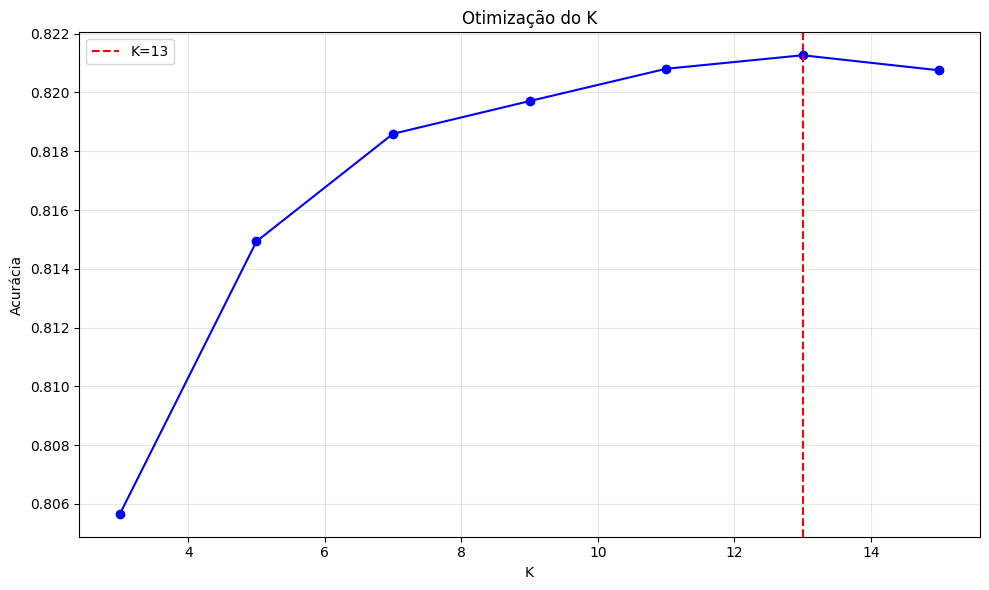

In [3]:
sistema = SistemaRecomendacaoMedica()

sistema.carregar_dados(
    'Final_Augmented_dataset_Diseases_and_Symptoms.csv',
    'Sintomas - Especialidade.csv'
)

sistema.analise_dados()

X_train, X_test, y_train, y_test = sistema.preparar_dados()

sistema.otimizar_k(X_train, y_train)

sistema.treinar(X_train, y_train)


# QUADRANTE 3 - Avaliação do Modelo e Geração de Gráficos


Avaliação do Modelo

Métricas de Performance:
Acurácia:  0.8208 (82.08%)
Precisão:  0.8263 (82.63%)
Recall:    0.8208 (82.08%)
F1-Score:  0.8213 (82.13%)

AUC-ROC (5 doenças mais comuns):
nose disorder                      : 0.9545
vulvodynia                         : 0.9730
cystitis                           : 0.9430
spondylosis                        : 0.9132
conjunctivitis due to allergy      : 0.9625

Comparação com baselines:
KNN:            0.8208
Aleatório:      0.0026
Popularidade:   0.0049
Ganho:          +81.59%

Desempenho por doença (top 10):

Doença                              | Prec. | Recall | F1
------------------------------------------------------------
nose disorder                       | 0.881 | 0.848  | 0.864
vulvodynia                          | 0.923 | 0.881  | 0.901
cystitis                            | 0.724 | 0.668  | 0.695
spondylosis                         | 0.760 | 0.626  | 0.686
conjunctivitis due to allergy       | 0.882 | 0.827  | 0.854
acute bronchi

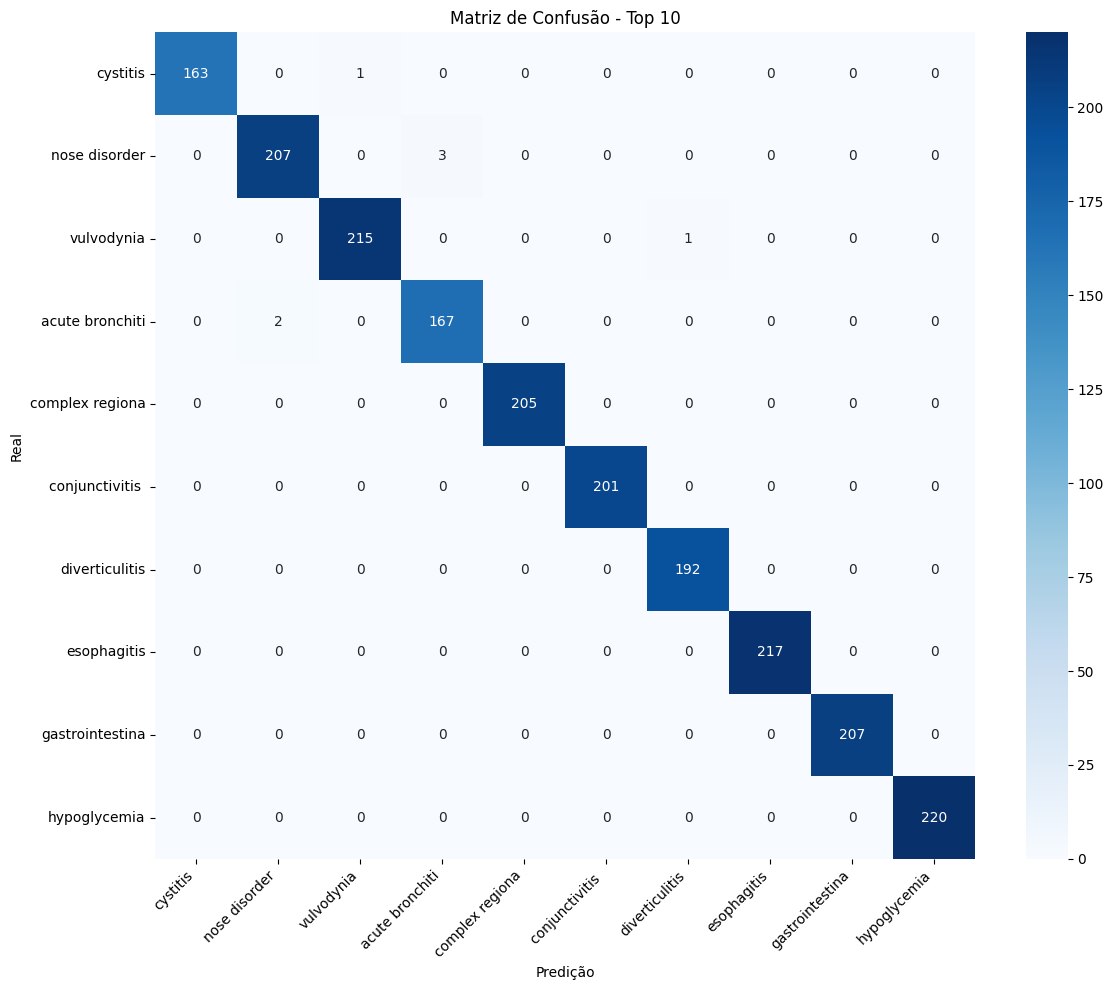

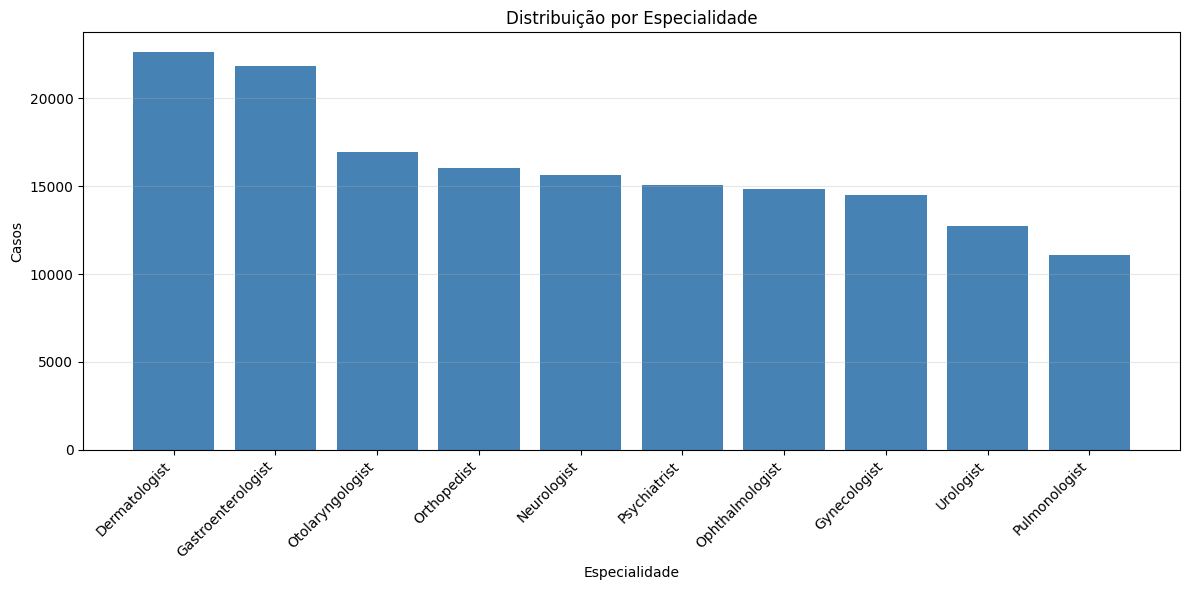

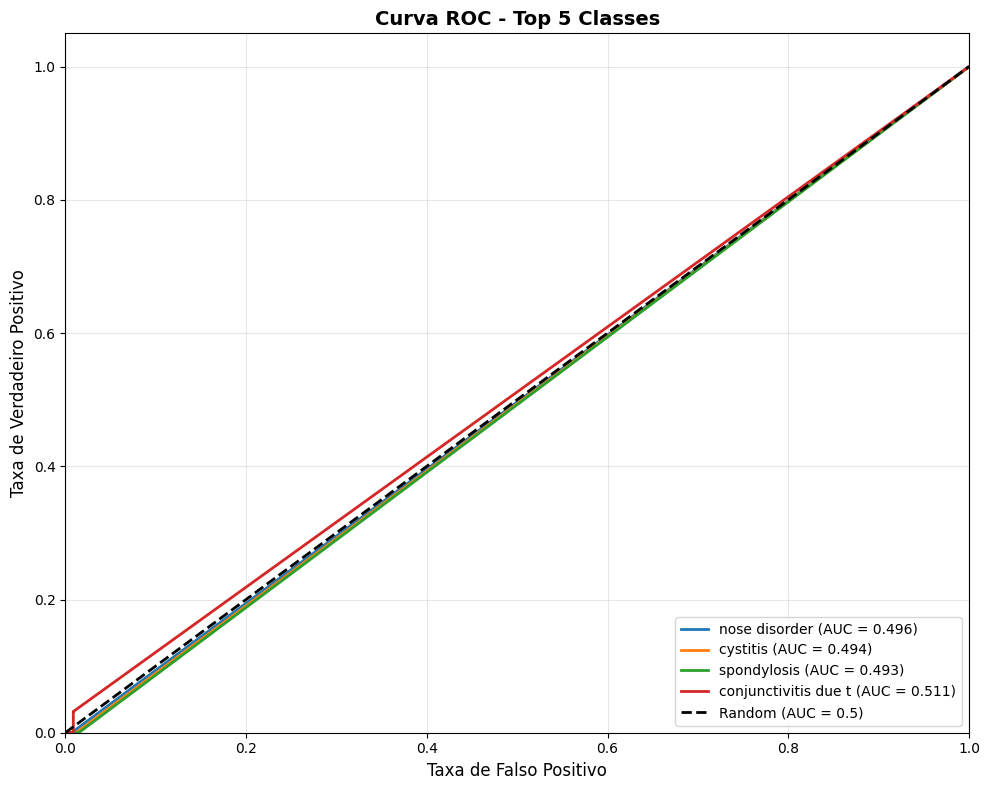

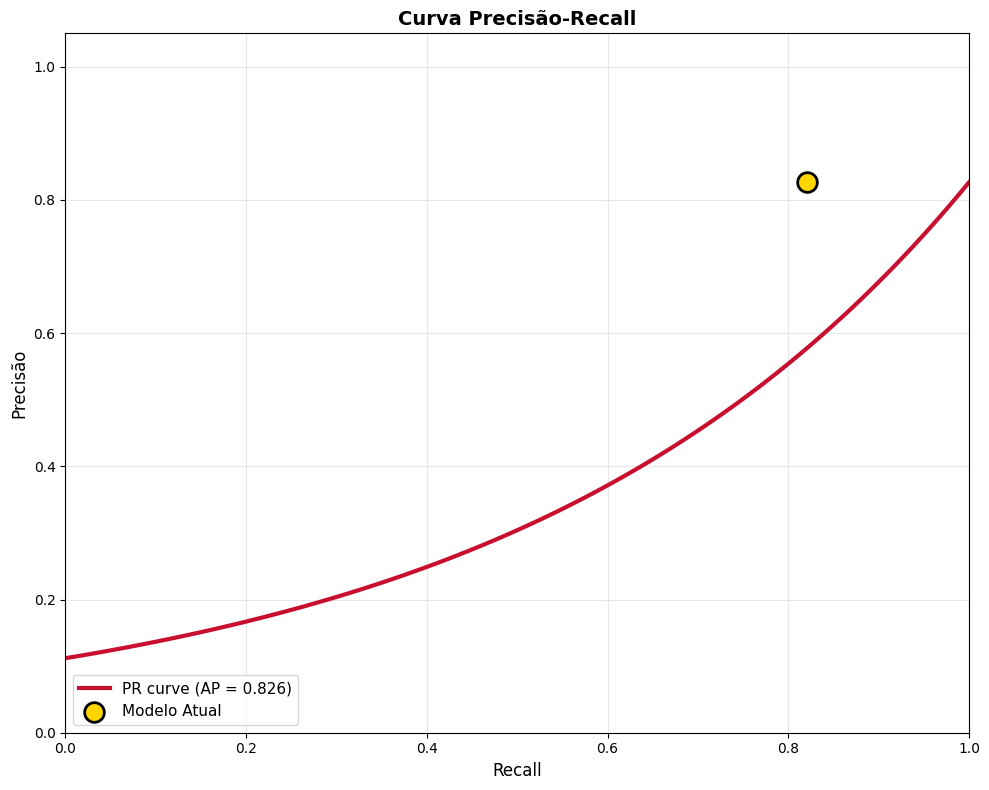

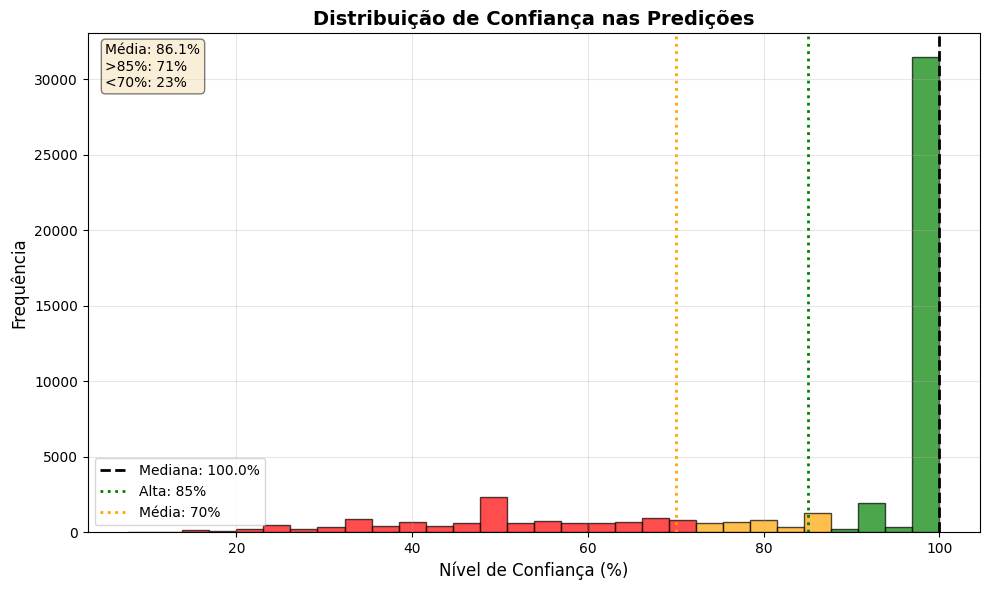


Comparando com outros algoritmos...
KNN-13         : 0.8208 (43ms)


In [ ]:
y_pred = sistema.avaliar(X_test, y_test)

sistema.plotar_matriz_confusao(y_test, y_pred)

sistema.plotar_especialidades()

sistema.plotar_curva_roc(y_test)

sistema.plotar_curva_precisao_recall()

sistema.plotar_distribuicao_confianca()

sistema.plotar_comparacao_algoritmos(X_train, y_train, X_test, y_test)

sistema.plotar_validacao_cruzada(X_train, y_train)

sistema.plotar_metricas_por_especialidade(y_test, y_pred)


 # QUADRANTE 4 - Teste Interativo de Predição com Sintomas

In [1]:
resultado = sistema.prever_por_nomes_sintomas([
    'anxiety and nervousness',
    'depression',
    'shortness of breath',
    'depressive or psychotic symptoms',
    'abnormal involuntary movements',
    'chest tightness',
    'palpitations',
    'irregular heartbeat',
    'breathing fast'
])

print("\nTeste do Sistema")
print(f"\nDiagnóstico: {resultado['doenca']}")
print(f"Especialista: {resultado['especialista']}")
print(f"Confiança: {resultado['confianca']:.1%}")
print("\nDiagnósticos similares:")
for i, d in enumerate(resultado['similares'][:5], 1):
    print(f"{i}. {d}")

NameError: name 'sistema' is not defined